In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
#calculating the filter size for Gaussian filtering based on a specified threshold T and standard deviation sigma. These 
#functions can be useful for dynamically determining the size of a Gaussian kernel for a given threshold and standard deviation

def sHalf(T, sigma):
    temp = -np.log(T) * 2 * (sigma ** 2)
    return np.round(np.sqrt(temp))

def calculate_filter_size(T, sigma):
    return 2*sHalf(T, sigma) + 1
#print(calculate_filter_size)

In [3]:
#The MaskGeneration function you've provided appears to be generating a 2D meshgrid representing the coordinates of a Gaussian 
#filter mask. This is a common approach in image processing to create a grid of coordinates for a filter kernel, which can then 
#be used for tasks like convolution.
#The MaskGeneration function relies on the calculate_filter_size and sHalf functions to determine the filter size and half-size 
#based on a given threshold T and standard deviation sigma. Here's how you can use this function:

def MaskGeneration(T, sigma):
    N = calculate_filter_size(T, sigma)
    shalf = sHalf(T, sigma)
    y, x = np.meshgrid(range(-int(shalf), int(shalf) + 1), range(-int(shalf), int(shalf) + 1))
    return x, y

In [4]:
#1: Gaussian(x, y, sigma): This function computes the value of a 2D Gaussian function at a given (x, y) position with a 
#specified standard deviation (sigma). The formula for the Gaussian function is used,

#2: calculate_gradient_X(x, y, sigma): This function calculates the partial derivative of the Gaussian function with respect to 
#x at a given (x, y) position and with a specified standard deviation (sigma).  

#3: calculate_gradient_Y(x, y, sigma): Similar to calculate_gradient_X, this function calculates the partial derivative of the 
#Gaussian function with respect to y at a given (x, y) position and with a specified standard deviation (sigma).

def Gaussian(x,y, sigma):
    temp = ((x ** 2) + (y ** 2)) / (2 * (sigma ** 2))
    return (np.exp(-temp))

def calculate_gradient_X(x,y, sigma):
    temp = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    return -((x * np.exp(-temp)) / sigma ** 2)

def calculate_gradient_Y(x,y, sigma):
    temp = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    return -((y * np.exp(-temp)) / sigma ** 2)

In [5]:
#pad(img, kernel): This function is responsible for padding an input image with a specified kernel. Padding is often necessary 
#when performing convolution to ensure that the output image has the same dimensions as the input image.
#img: The input image as a NumPy array.
#kernel: The convolution kernel as a NumPy array.
#The function calculates the required padding size, creates a larger zero-filled image (padded), and inserts the original image
#at the center of the padded image. The function returns the padded image.

#smooth(img, kernel=None): This function applies smoothing (convolution) to an input image using a specified or default kernel. 
#If no kernel is provided, a simple 3x3 averaging kernel is used.
#img: The input image as a NumPy array.
#kernel: An optional convolution kernel as a NumPy array.
#The function first checks if a custom kernel is provided. If not, it uses a 3x3 kernel with all elements set to 1. It then 
#computes the dimensions of the kernel.


def pad(img, kernel):
    r, c = img.shape
    kr, kc = kernel.shape
    padded = np.zeros((r + kr,c + kc), dtype=img.dtype)
    insert = np.uint((kr)/2)
    padded[insert: insert + r, insert: insert + c] = img
    return padded
            
def smooth(img, kernel=None):
    if kernel is None:
        mask = np.array([[1,1,1],[1,1,1],[1,1,1]])
    else:
        mask = kernel
    i, j = mask.shape
    output = np.zeros((img.shape[0], img.shape[1]))           
    image_padded = pad(img, mask)
    for x in range(img.shape[0]):    
        for y in range(img.shape[1]):
            output[x, y] = (mask * image_padded[x:x+i, y:y+j]).sum() / mask.sum()  
    return output

In [6]:
#The Create_Gx and Create_Gy functions appear to be related to creating gradient images (image derivatives) in the x and y 
#directions based on input images fx and fy. These functions take input images fx and fy, calculate the gradients using the 
#calculate_gradient_X and calculate_gradient_Y functions, and then scale the gradient values to the range [0, 255] by multiplying
#by 255 and rounding to the nearest integer.


def Create_Gx(fx, fy):
    gx = calculate_gradient_X(fx, fy, sigma)
    gx = (gx * 255)
    return np.around(gx)

def Create_Gy(fx, fy):    
    gy = calculate_gradient_Y(fx, fy, sigma)
    gy = (gy * 255)
    return np.around(gy)

In [7]:
#The ApplyMask function you've provided appears to be a convolution operation for applying a kernel to an input image. 
#Convolution is a fundamental operation in image processing, and it is used for various tasks such as filtering, smoothing, and 
#feature extraction.

def ApplyMask(image, kernel):
    i, j = kernel.shape
    kernel = np.flipud(np.fliplr(kernel))    
    output = np.zeros_like(image)           
    image_padded = pad(image, kernel)
    for x in range(image.shape[0]):    
        for y in range(image.shape[1]):
            output[x, y] = (kernel * image_padded[x:x+i, y:y+j]).sum()        
    return output

In [8]:
#The functions Gradient_Magnitude and Gradient_Direction are designed to compute the gradient magnitude and gradient direction 
#from gradient components fx and fy.


def Gradient_Magnitude(fx, fy):
    mag = np.zeros((fx.shape[0], fx.shape[1]))
    mag = np.sqrt((fx ** 2) + (fy ** 2))
    mag = mag * 100 / mag.max()
    return np.around(mag)

def Gradient_Direction(fx, fy):
    g_dir = np.zeros((fx.shape[0], fx.shape[1]))
    g_dir = np.rad2deg(np.arctan2(fy, fx)) + 180
    return g_dir

In [9]:
def Digitize_angle(Angle):
    quantized = np.zeros((Angle.shape[0], Angle.shape[1]))
    for i in range(Angle.shape[0]):
        for j in range(Angle.shape[1]):
            if 0 <= Angle[i, j] <= 22.5 or 157.5 <= Angle[i, j] <= 202.5 or 337.5 < Angle[i, j] < 360:
                quantized[i, j] = 0
            elif 22.5 <= Angle[i, j] <= 67.5 or 202.5 <= Angle[i, j] <= 247.5:
                quantized[i, j] = 1
            elif 67.5 <= Angle[i, j] <= 122.5 or 247.5 <= Angle[i, j] <= 292.5:
                quantized[i, j] = 2
            elif 112.5 <= Angle[i, j] <= 157.5 or 292.5 <= Angle[i, j] <= 337.5:
                quantized[i, j] = 3
    return quantized
    
def Non_Max_Supp(qn, magni, D):
    M = np.zeros(qn.shape)
    a, b = np.shape(qn)
    for i in range(a-1):
        for j in range(b-1):
            if qn[i,j] == 0:
                if  magni[i,j-1]< magni[i,j] or magni[i,j] > magni[i,j+1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
            if qn[i,j]==1:
                if  magni[i-1,j+1]<= magni[i,j] or magni[i,j] >= magni[i+1,j-1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0       
            if qn[i,j] == 2:
                if  magni[i-1,j]<= magni[i,j] or magni[i,j] >= magni[i+1,j]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
            if qn[i,j] == 3:
                if  magni[i-1,j-1]<= magni[i,j] or magni[i,j] >= magni[i+1,j+1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
    return M

def color(quant, mag):
    color = np.zeros((mag.shape[0], mag.shape[1], 3), np.uint8)
    a, b = np.shape(mag)
    for i in range(a-1):
        for j in range(b-1):
            if quant[i,j] == 0:
                if mag[i,j] != 0:
                    color[i,j,0] = 255
                else:
                    color[i,j,0] = 0
            if quant[i,j] == 1:
                if mag[i,j] != 0:
                    color[i,j,1] = 255
                else:
                    color[i,j,1] = 0
            if quant[i,j] == 2:
                if mag[i,j] != 0:
                    color[i,j,2] = 255
                else:
                    color[i,j,2] = 0
            if quant[i,j] == 3:
                if mag[i,j] != 0:
                    color[i,j,0] = 255
                    color[i,j,1] = 255
                    
                else:
                    color[i,j,0] = 0
                    color[i,j,1] = 0
    return color

In [10]:
#g_suppressed: This is the image resulting from non-maximum suppression, which typically contains edge pixels with their 
#gradient magnitudes.

#low_threshold: The low threshold is a value below which pixel values are considered non-edge pixels.

#high_threshold: The high threshold is a value above which pixel values are considered strong edge pix#els.

def _double_thresholding(g_suppressed, low_threshold, high_threshold):
    g_thresholded = np.zeros(g_suppressed.shape)
    for i in range(0, g_suppressed.shape[0]):		# loop over pixels
        for j in range(0, g_suppressed.shape[1]):
            if g_suppressed[i,j] < low_threshold:	# lower than low threshold
                g_thresholded[i,j] = 0
            elif g_suppressed[i,j] >= low_threshold and g_suppressed[i,j] < high_threshold: 	# between thresholds
                g_thresholded[i,j] = 128
            else:					        # higher than high threshold
                g_thresholded[i,j] = 255
    return g_thresholded

In [11]:
#g_thresholded: This is the edge map after double thresholding, where pixels are categorized as strong (value 255), weak 
#(value 128), or non-edge (value 0).

def _hysteresis(g_thresholded):
    g_strong = np.zeros(g_thresholded.shape)
    for i in range(0, g_thresholded.shape[0]):		# loop over pixels
        for j in range(0, g_thresholded.shape[1]):
            val = g_thresholded[i,j]
            if val == 128:			# check if weak edge connected to strong
                if g_thresholded[i-1,j] == 255 or g_thresholded[i+1,j] == 255 or g_thresholded[i-1,j-1] == 255 or g_thresholded[i+1,j-1] == 255 or g_thresholded[i-1,j+1] == 255 or g_thresholded[i+1,j+1] == 255 or g_thresholded[i,j-1] == 255 or g_thresholded[i,j+1] == 255:
                    g_strong[i,j] = 255		# replace weak edge as strong
            elif val == 255:
                g_strong[i,j] = 255		# strong edge remains as strong edge
    return g_strong

Specify sigma and T value Also calculate Gradient masks
---

In [12]:
sigma = 0.5
T = 0.3
x, y = MaskGeneration(T, sigma)
gauss = Gaussian(x, y, sigma)

In [13]:
gx = -Create_Gx(x, y)
gy = -Create_Gy(x, y)

Reading and converting image into grayscale
----

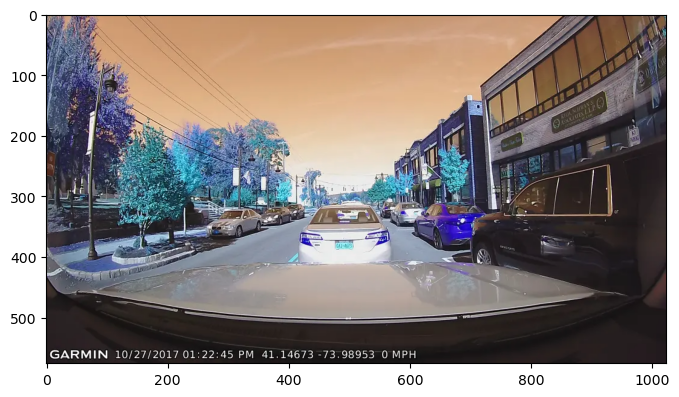

In [37]:
image = cv2.imread("F:\\MS\\SRH study\\III sem\\Future mobility\\dashcam.jpg")
plt.figure(figsize = (8,8))
plt.imshow(image)
plt.show()

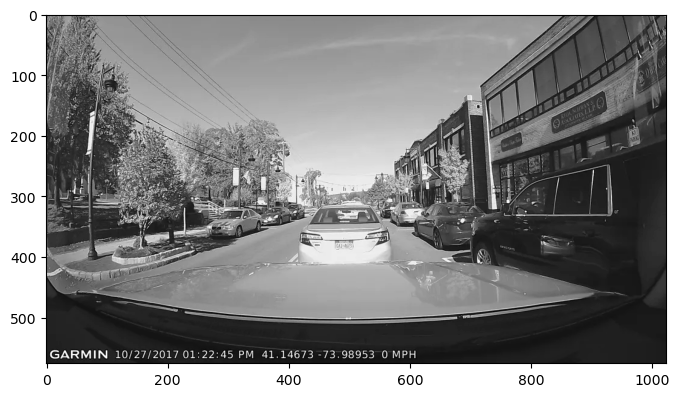

In [28]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (8,8))
plt.imshow(gray, cmap='gray')
plt.show()

Gaussian Smoothing/Noise reduction (Smoothing)
-----------

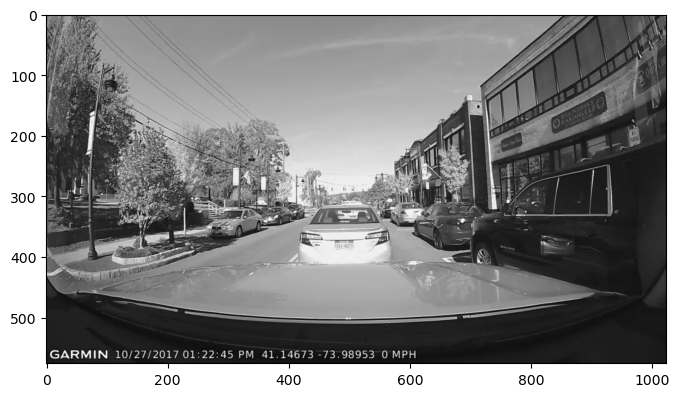

In [27]:
smooth_img = smooth(gray, gauss)
plt.figure(figsize = (8,8))
plt.imshow(smooth_img, cmap='gray')

Step 2 Gradient Calculation(Applying the Gradient masks)
---------------------------

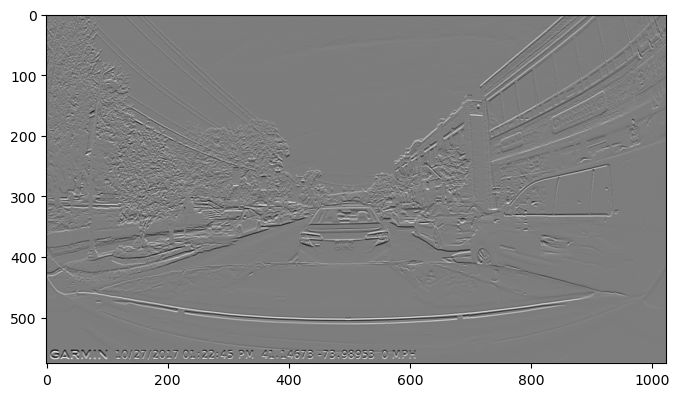

In [29]:
fx = ApplyMask(smooth_img, gx)
plt.figure(figsize = (8,8))
plt.imshow(fx, cmap='gray')

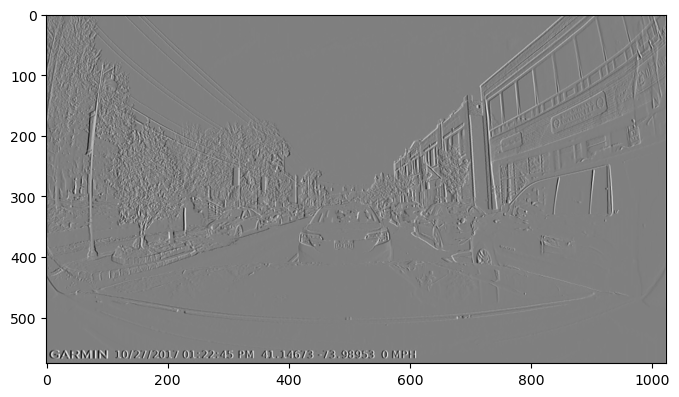

In [30]:
fy = ApplyMask(smooth_img, gy)
plt.figure(figsize = (8,8))
plt.imshow(fy, cmap='gray')

 Gradient magnitude
----------

max 100
min 0


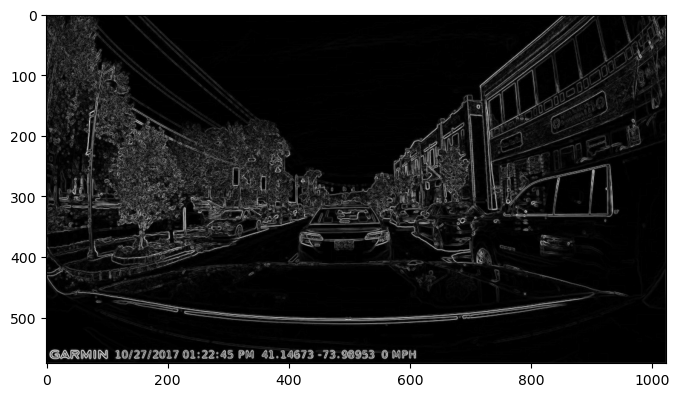

In [31]:
mag = Gradient_Magnitude(fx, fy)
mag = mag.astype(int)
plt.figure(figsize = (8,8))
plt.imshow(mag, cmap='gray')
print('max', mag.max())
print('min', mag.min())

Gradient Direction
---

max 360.0
min 0.0


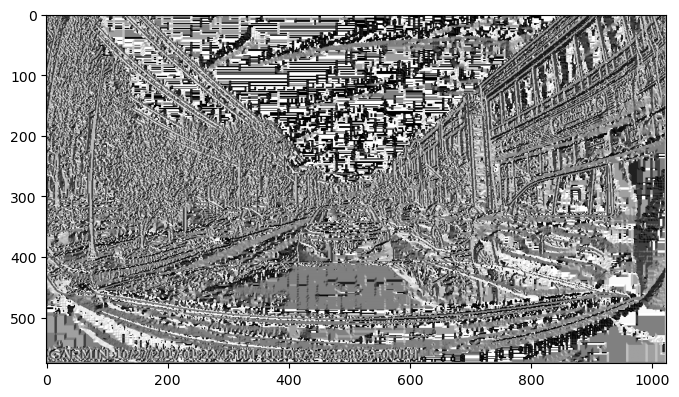

In [32]:
Angle = Gradient_Direction(fx, fy)
plt.figure(figsize = (8,8))
plt.imshow(Angle, cmap='gray')
print('max', Angle.max())
print('min', Angle.min())

Step 3 Non-maximum Suppression: Quantization of angles
------

max 100.0
min 0.0


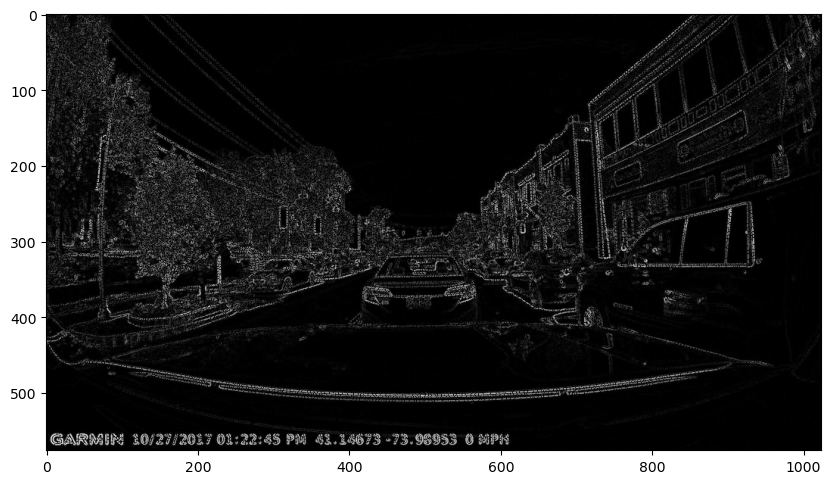

In [33]:
quantized = Digitize_angle(Angle)
nms = Non_Max_Supp(quantized, Angle, mag)
plt.figure(figsize = (10,10))
plt.imshow(nms, cmap='gray')
print('max', nms.max())
print('min', nms.min())

Step 4: Double Threshold
-----

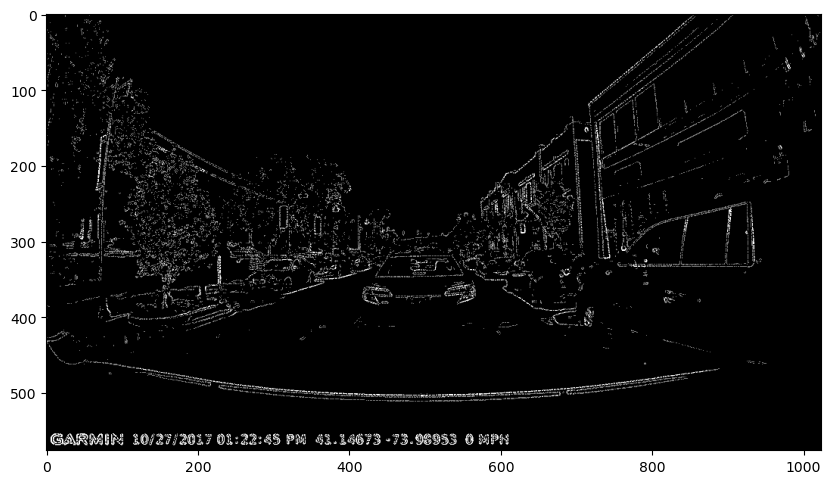

In [34]:
threshold = _double_thresholding(nms, 30, 60)
cv2.imwrite('double_thresholded.jpg', threshold )
plt.figure(figsize = (10,10))
plt.imshow(threshold, cmap='gray')

Step 5: Hysteresis
---------

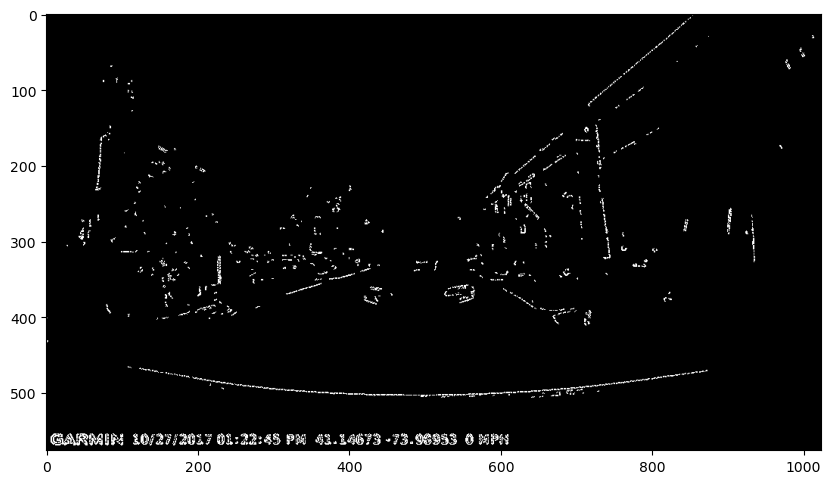

In [35]:
hys = _hysteresis(threshold)
cv2.imwrite('Result.jpg', hys)
plt.figure(figsize = (10,10))
plt.imshow(hys, cmap='gray')